# HiddenLayer Training Demo - TensorFlow

In [1]:
import os
import time
import random
import numpy as np
import tensorflow as tf
import hiddenlayer as hl

# Basic Use Case

To track your training, you need to use two Classes: History to store the metrics, and Canvas to draw them.
This example simulates a training loop.

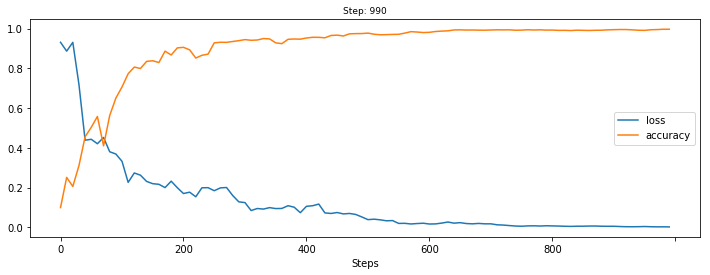

In [3]:
# A History object to store metrics
h = hl.History()

# A Canvas object to draw the metrics
c = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(1000):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy += (1 - accuracy) * np.random.uniform(-.09, 0.1)

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        # Store metrics in the history object
        h.log(step, loss=loss, accuracy=accuracy)

        # Plot the two metrics in one graph
        c.draw_plot(h["loss"], h["accuracy"])

        time.sleep(0.1)

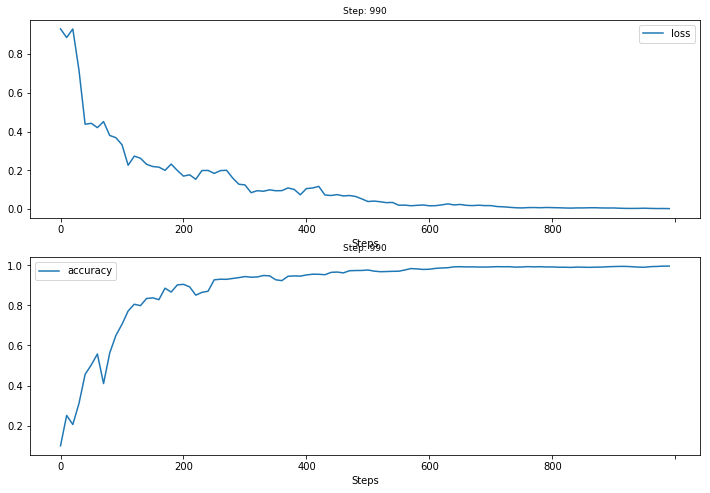

In [4]:
# Or we can plot them in two separate graphs (in one figure) by 
# calling draw_plot() twice inside a "with" context
with c:
    c.draw_plot(h["loss"])
    c.draw_plot(h["accuracy"])

## Running without a GUI

If the training loop is running on a server without a GUI, then track it by printing the progress status and periodically saving a snapshot of the graphs. See `demos/history_demo.py` for an example.

First, set matplotlib backend to Agg.
```Python
# Set matplotlib backend to Agg. MUST be done BEFORE importing hiddenlayer
import matplotlib
matplotlib.use("Agg")
```

Then, in the training loop:
```
    # Print progress status
    h.progress()

    # Occasionally, save a snapshot of the graphs
    c.draw_plot(h["loss"], h["accuracy"])
    c.save("pytorch_demo.png".format(step))
    
```

In [5]:
# The progress() method prints the metrics of the last step.
h.progress()

Step 990: loss: 0.0019984773657024417  accuracy: 0.9962809955452587  


In [6]:
# The History object store the metrics in RAM, which is often good enough for simple 
# expriments. To keep the history, you can save/load them with.
# h.save("basic.pkl")

# And load them with
# h.load("basic.pkl")

# More Metric Types

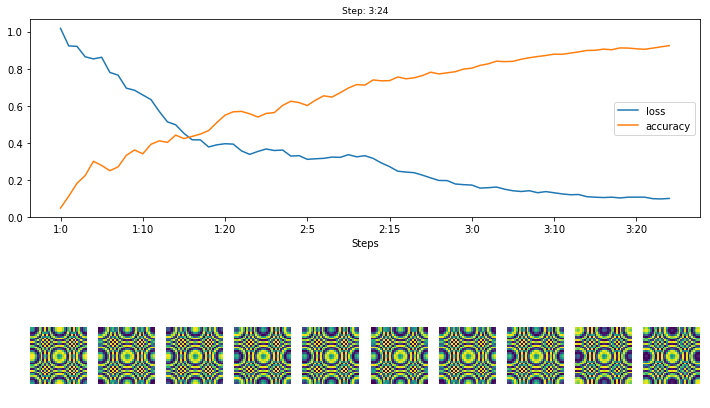

In [7]:
# History and Canvas
h = hl.History()
c = hl.Canvas()

# Simulate a training loop with TODO two metrics: loss and accuracy
loss = 1
accuracy = 0
image = np.zeros([10, 32, 32, 3])
for epoch in range(1, 4):
    for batch_ix in range(25):
        # Fake metrics
        loss -= loss * np.random.uniform(-.05, 0.1)
        accuracy += (1 - accuracy) * np.random.uniform(-.05, 0.1)
        
        # Fake image metric
        # Useful to track images generated by a GAN for example
        image = np.sin(np.sum(((np.indices([32, 32]) - 16) * 0.5 * accuracy) ** 2, 0))

        # Store metrics in the history object
        # TODO: consider a cleaner way to represent epochs
        step = "{}:{}".format(epoch, batch_ix)
        h.log(step, loss=loss, accuracy=accuracy)

        # Store an image metric
        # You can log multiple metrics in one call (as above), or
        # in separate calls so it can be done from where it's convenient
        # in your code.
        h.log(step, image=image[np.newaxis, ...])

        # Plot the two metrics in one graph, and the images reel
        # in a separate under it.
        with c:
            c.draw_plot(h["loss"], h["accuracy"])
            c.draw_images(h["image"])

        time.sleep(0.1)

## Model Training Example

In [2]:
# Import the model code
from tf_cifar10 import CIFAR10

# Create data directory in project root (to download dataset to)
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
DATA_DIR = os.path.join(ROOT_DIR, "test_data")

In [3]:
# CIFAR10 dataset and model
batch_size = 128
cifar10 = CIFAR10(batch_size=batch_size, data_dir=DATA_DIR)

In [4]:
# Inspect data and labels
hl.write("cifar10.train_data", cifar10.train_data)
hl.write("cifar10.train_labels", cifar10.train_labels)
hl.write("cifar10.test_data", cifar10.test_data)
hl.write("cifar10.test_labels", cifar10.test_labels)

cifar10.train_data	Tensor  float64 (50000, 32, 32, 3)  min: 0.000  max: 1.000
cifar10.train_labels	Tensor  float64 (50000, 10)  min: 0.000  max: 1.000
cifar10.test_data	Tensor  float64 (10000, 32, 32, 3)  min: 0.000  max: 1.000
cifar10.test_labels	Tensor  float64 (10000, 10)  min: 0.000  max: 1.000


In [5]:
# Build the TensorFlow Graph
tf_graph = tf.Graph()

with tf_graph.as_default():
    # Setup placeholders/vars
    inputs = tf.placeholder(tf.float32, shape=(batch_size, cifar10.img_size, cifar10.img_size, cifar10.num_channels))
    # Build model
    predictions = cifar10.model(inputs)



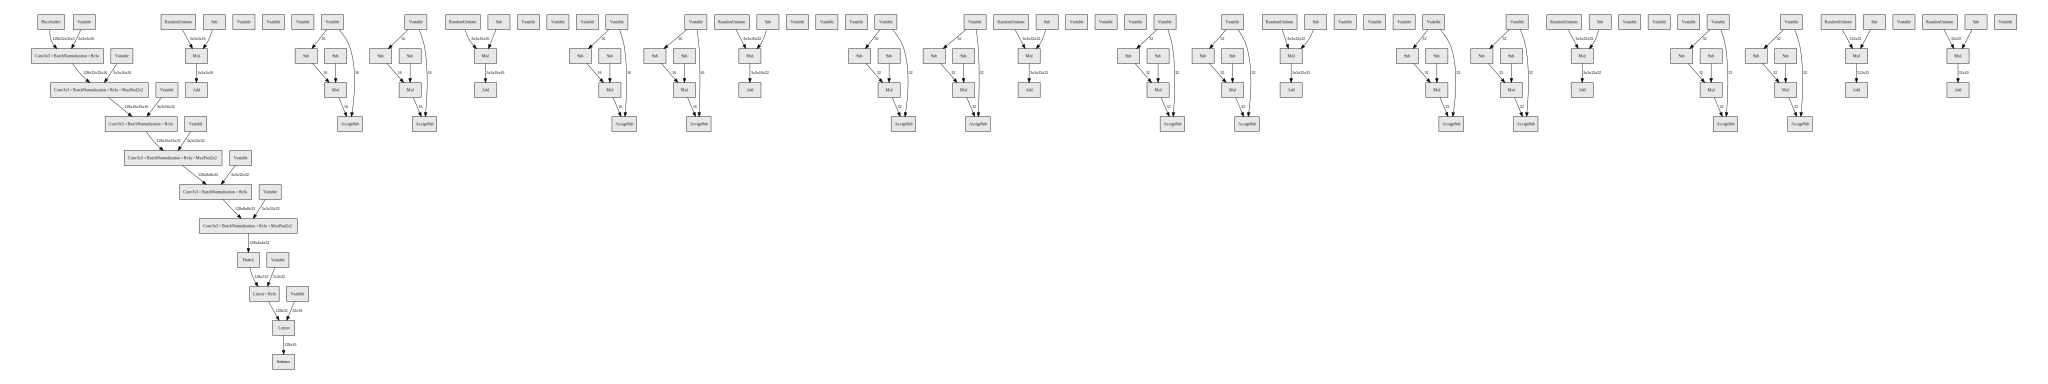

In [6]:
# Display graph
hl.Graph(tf_graph)

## Visualize Training Progress

In [7]:
# Setup TF training session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

In [8]:
# Setup placeholders/vars
inputs = tf.placeholder(tf.float32, shape=(batch_size, cifar10.img_size, cifar10.img_size, cifar10.num_channels))
outputs = tf.placeholder(tf.float32, shape=[batch_size, cifar10.num_classes])
g_step = tf.Variable(initial_value=0, trainable=False)

In [9]:
# Build model
predictions = cifar10.model(inputs)

In [10]:
# Setup loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=outputs))
optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9).minimize(loss, global_step=g_step)

In [11]:
# Setup metric
accurate_preds = tf.equal(tf.argmax(predictions, axis=1), tf.argmax(outputs, axis=1))
accuracy = tf.reduce_mean(tf.cast(accurate_preds, tf.float32))

In [29]:
# Instantiate history and canvas
h = hl.History()
c = hl.Canvas()

In [14]:
# Run the initializer
sess.run(tf.global_variables_initializer())

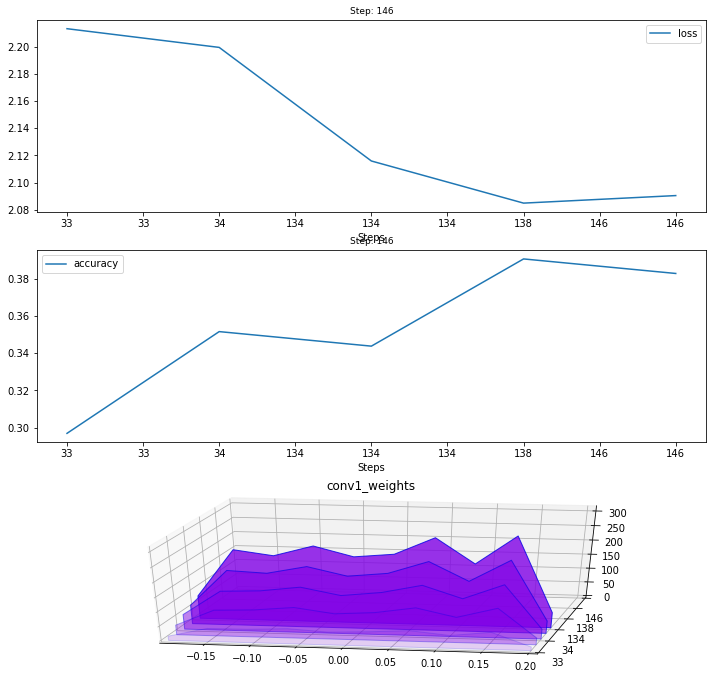

In [ ]:
# Run training loop on GPU
epochs = 2
# with tf.device('/gpu:0'): # Set to '/cpu:0' if you don't have a GPU
for epoch in range(epochs):
    batches, _ = divmod(cifar10.train_len, batch_size)
    for batch in range(batches):
        # Fetch training samples
        _input = cifar10.train_data[batch*batch_size : (batch+1)*batch_size]
        _output = cifar10.train_labels[batch*batch_size : (batch+1)*batch_size]

        # Train model
        train_ops = [g_step, optimizer, loss, accuracy]
        step, _, _loss, _accuracy = sess.run(train_ops, feed_dict={inputs : _input, outputs : _output})

        # Print stats
        if batch & batch % 100 == 0:
            _weights = tf.get_default_graph().get_tensor_by_name('conv1/conv2d/kernel:0').eval(session=sess)
            # TODO: include epoch
            h.log(step,
                  loss=_loss, accuracy=_accuracy, conv1_weights=_weights)
            with c:
                c.draw_plot(h["loss"])
                c.draw_plot(h["accuracy"])
                c.draw_hist(h["conv1_weights"])

In [ ]:
# Terminate training session
sess.close()